Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 2  
Due: May 6, 2020  

---
## Part 2 - Belousov-Zhabotinsky data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
wd = "/mnt/Backups/jmhu"
data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"

### Load data

### Question 1. Download data

In [4]:
if not os.path.exists(data_dir + "BZ.mat"):
    print("Download data")
    !wget -P $data_dir courses.washington.edu/amath582/BZ.mat 
else:
    print("Data downloaded")

Data downloaded


In [5]:
f = h5py.File(data_dir + 'BZ.mat','r')
data = f.get('BZ_tensor')
data = np.array(data)

In [6]:
data.shape

(1200, 451, 351)

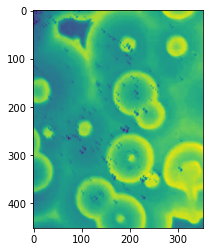

In [7]:
plt.imshow(data[0])

In [8]:
import matplotlib.animation as animation

In [9]:
# # Randomly subset data
# random_subset = np.random.choice(np.arange(data.shape[0]), size=int(0.25*data.shape[0]))
# random_subset.shape
# data_subset = data[random_subset, :, :]

# Since this is a video, frames are sequential and order matters. 
data_subset = data[::4, :, :]
data_subset.shape

(300, 451, 351)

In [10]:
fig = plt.figure()

# Create list of image frames
ims = []
for frame in data_subset:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

# Create animation artist using figure instance and frame list    
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1e5)

# Don't show the figure
plt.close(ani._fig)

# Call function to display the animation
from IPython.display import HTML
HTML(ani.to_html5_video())

# Save as mp4
# ani.save('dynamic_images.mp4')

### DMD and time-delay DMD model with forecasts, determine if any latent variables with Hankel matrix

#### Define functions

In [32]:
def DMD(X, Xprime, r, dt=2):
    '''Dynamic Mode Decomposition Function from book'''
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    Omega = np.log(np.diag(Lambda))/dt
    return Phi, Omega, b, Lambda

def forecast_dmdintro(Phi, Omega, t, b, r, dt):
    u_modes = np.zeros((r, t))
    time_vector = dt*np.arange(-1, t-1)
    
    for i in np.arange(0, t):
        u_modes[:, i]=b * np.exp(Omega * time_vector[i])

    Xdmd = Phi @ u_modes
#     print(t, u_modes.shape, time_vector.shape, Xdmd.shape)
    return(Xdmd)

#### Set-up 

##### Try reshaping the data

In [21]:
data_subset = data[::4, :, :]
print(data_subset.shape)

data_subset = np.reshape(data_subset, (data_subset.shape[0], data_subset.shape[1]*data_subset.shape[2]))
print(data_subset.shape)

(300, 451, 351)
(300, 158301)


In [22]:
data_subset_reshaped = np.reshape(data_subset, 
                                  (data_subset.shape[0], 451, 351))

# Try reshaping the data
print(data_subset_reshaped.shape)

(300, 451, 351)


In [23]:
np.all(data[::4, :, :] == data_subset_reshaped)

True

In [24]:
# Two snapshots of the system encompassing the entire time series
X = data_subset[:-1, :]
Xprime = data_subset[1:, :]
print(X.shape, Xprime.shape)

# Transpose matrices - observations (states) first, time step second
X=X.T
Xprime=Xprime.T
print(X.shape, Xprime.shape)

(299, 158301) (299, 158301)
(158301, 299) (158301, 299)


In [25]:
%%time

# DMD it
r=10

Phi, Omega, b, Lambda = DMD(X, Xprime, r)

print(" Phi : Omega : b ", )
print(Phi.shape, Omega.shape, b.shape)

 Phi : Omega : b 
(158301, 10) (10,) (10,)
CPU times: user 1min 3s, sys: 2.05 s, total: 1min 5s
Wall time: 3.66 s


In [35]:
%%time
Xdmd_func = forecast_dmdintro(Phi, Omega, t, b, r, dt)

<ipython-input-32-7d55a3a2b7c8>:28: ComplexWarning: Casting complex values to real discards the imaginary part
  u_modes[:, i]=b * np.exp(Omega * time_vector[i])


299 (10, 299) (299,) (158301, 299)
CPU times: user 2.8 s, sys: 11.8 s, total: 14.6 s
Wall time: 737 ms


In [39]:
b.shape, Omega.shape, Phi.shape, Xdmd.shape

((10,), (10,), (158301, 10), (158301, 299))

/home/jmhu/miniconda/envs/amath/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jmhu/miniconda/envs/amath/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


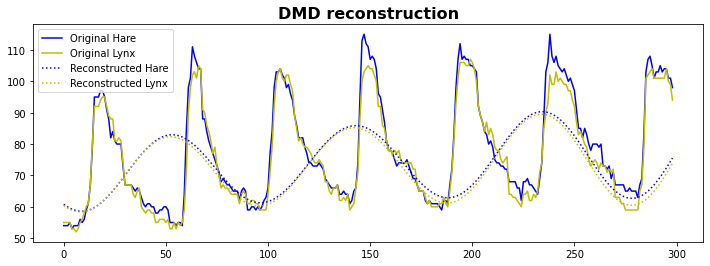

In [44]:
h=0
l=1

labels=["Hare", "Lynx"]

plt.figure(figsize=(12, 4))
plt.plot(X.T[:,h], "b", label=str("Original " + labels[h]))
plt.plot(X.T[:,l], "y", label=str("Original " + labels[l]))

plt.plot(Xdmd.T[:,h], "b:", label="Reconstructed " + labels[h])
plt.plot(Xdmd.T[:,l], "y:", label="Reconstructed " + labels[l])

plt.title("DMD reconstruction", fontsize=fontsize, weight=weight);
plt.legend()